# A Study on the Robustness of CAPTCHA Recognition Models Against Various Types of Noise

**Authors:** Yann Gautier, Noé Idesheim, Titouan Constance

---

CAPTCHAs remain a standard for web security. While modern Deep Learning models (CNNs) solve them with ease on clean images, their reliability diminishes when the image is degraded.

**The central question of this project is as follows:**
> *How does image alteration via the injection of different noise types impact the resolution of CAPTCHAs by recognition models?*

We will focus on:
1.  The generation of a **synthetic CAPTCHA dataset** (based on MNIST).
2.  The training of a **Multi-Head CNN** capable of recognizing 4 digits simultaneously.
3.  The evaluation of **robustness** against two noise types (Gaussian, Salt & Pepper).

### Technical Environment
To set up the necessary environment for this project, please refer to the project's `README.md` file.

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns 

# Configuration for Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Display Configuration
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_theme(style="whitegrid")

## 1. Data Pipeline: Construction of a CAPTCHA Dataset

Our data generation strategy relies on the assembly of handwritten digits derived from the MNIST dataset.

### Generation Process
1.  **Individual Pre-processing**: Each MNIST digit (28x28) is converted, rendering the black background transparent (Alpha channel).
2.  **Assembly & Transformations**: 4 digits are arranged side-by-side with random variations:
    * **Rotation** (slight).
    * **Scaling**.
3.  **Formatting**: The ensemble is placed on a unified black background and resized to **100x110 pixels**.

To mitigate **overfitting** (preventing the model from memorizing noisy images), noise is not stored permanently. Instead, it is injected dynamically **on-the-fly** during each training or prediction batch.

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\yanno\AppData\Local\Temp\ipykernel_9496\2446637166.py:5: SyntaxWarning: invalid escape sequence '\d'
  loader = MnistDataloader(data_dir='..\data')
c:\Users\yanno\OneDrive\Documents\GitHub\Python-Data-2A-ENSAE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading original data...
Reading 3 images (random selection)...
Reading 2 images (random selection)...
Displaying 3 training images and 2 test images


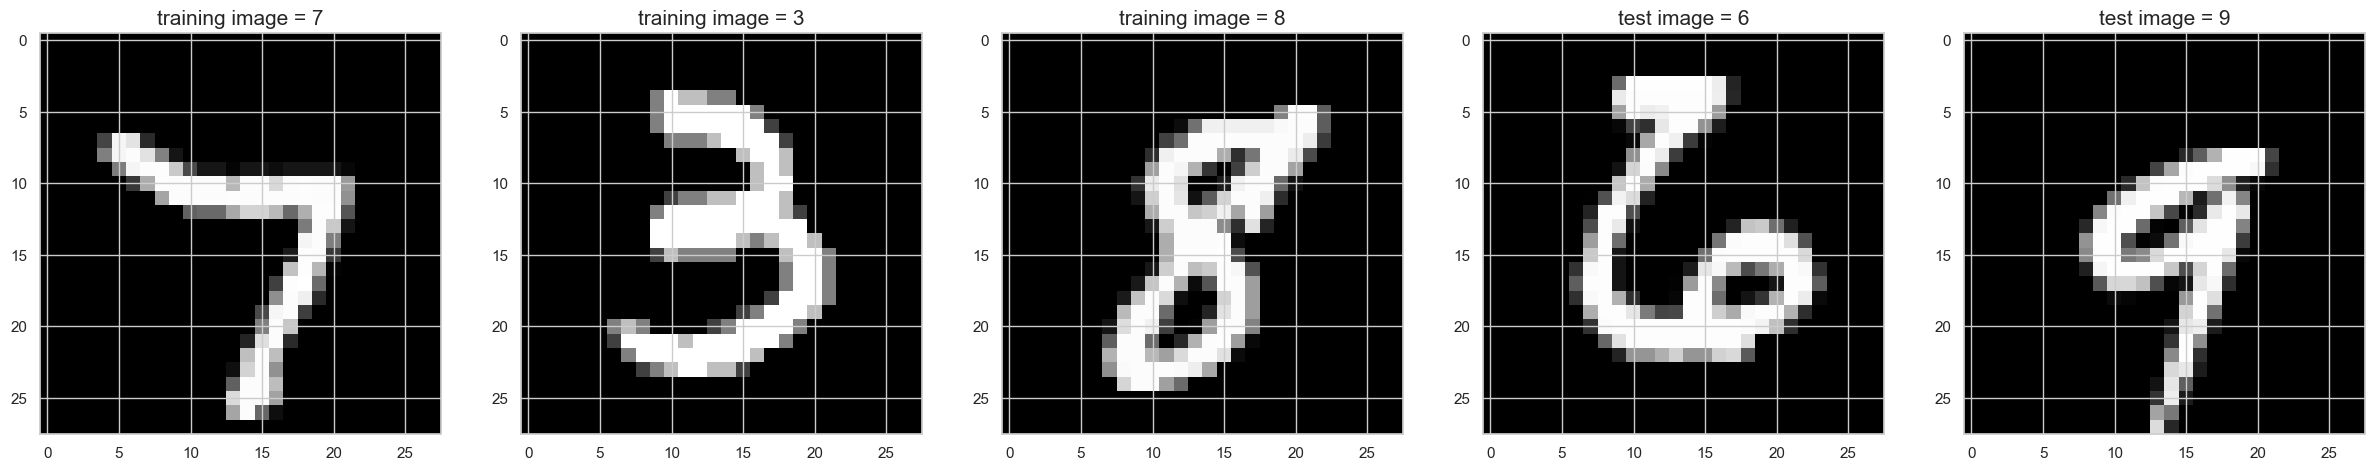

Génération Test  (20000) : 100%|██████████| 20000/20000 [01:46<00:00, 187.19it/s]



Saving to ..\data\captcha_data\captcha_dataset.h5...
CAPTCHA dataset created successfully!
Loading 3 training images (random selection)...
Loading 2 test images (random selection)...
CAPTCHA dataset loaded successfully!


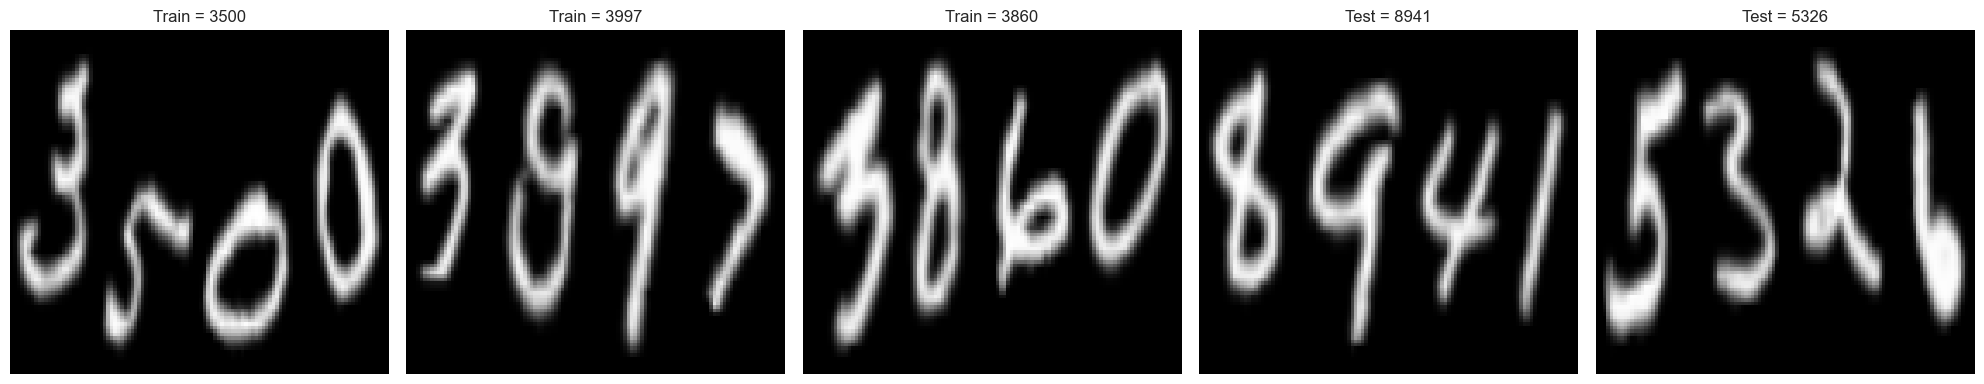

Displaying 3 training CAPTCHAs and 2 test CAPTCHAs
Loading 3 training images (random selection)...
Loading 2 test images (random selection)...
CAPTCHA dataset loaded successfully!
Applying salt_and_pepper noise (grayscale mode) to CAPTCHA images (factor: 0.1)...


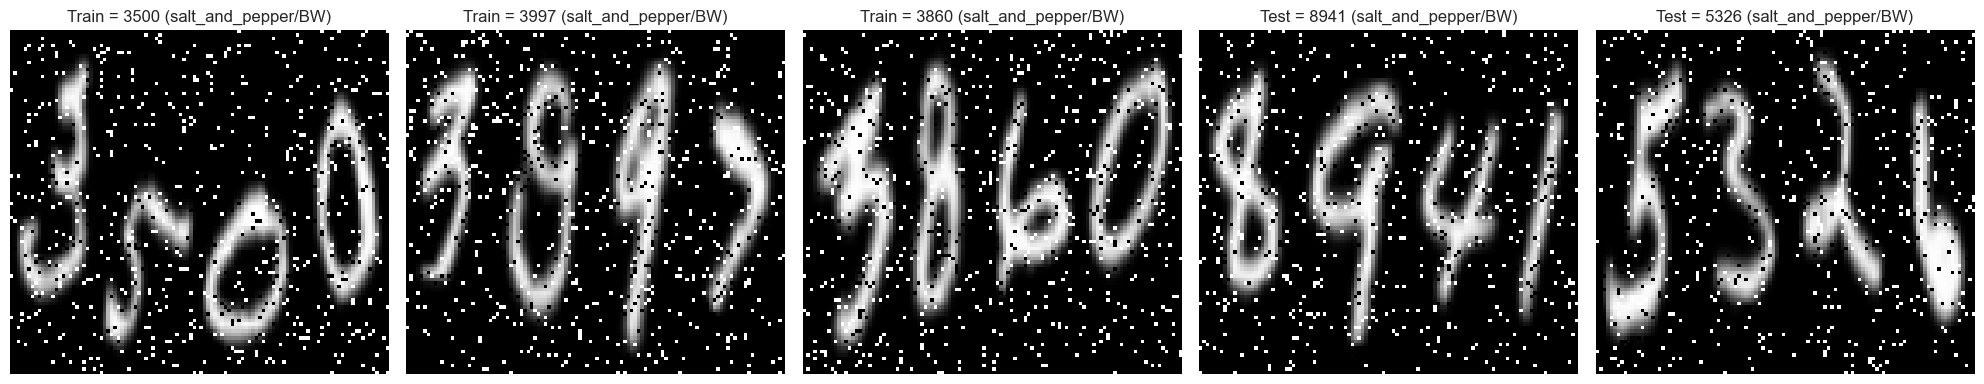

Displaying 3 training CAPTCHAs and 2 test CAPTCHAs


In [2]:
from MNIST import MnistDataloader 
import matplotlib.pyplot as plt
import numpy as np

loader = MnistDataloader(data_dir='..\data')

loader.download_mnist()

loader.show_images(num_train=3, num_test=2, seed=42)

loader.create_captcha_dataset(num_train=100_000, num_test=20_000, seed=42)

loader.show_captcha(num_train=3, num_test=2, seed=42)

loader.show_captcha(num_train=3, num_test=2, apply_noise=True, noise_type='salt_and_pepper', noise_factor=0.1, seed=42)


### Technical Details on Methods Used in `MNIST.py`

For a complete understanding of the data pipeline, here is a quick summary of the key methods/functions we use in the `MnistDataloader` class (in `MNIST.py`). They are organized by role:

1. **Loading Raw Data**:
   - `download_mnist()`: Downloads the MNIST dataset from Kaggle and stores it locally.
   - `read_images_labels(images_filepath, labels_filepath, ...)`: Reads MNIST images and labels from binary files (idx3-ubyte format), with support for random or sequential image selection.
   - `load_data(...)`: Loads training and test MNIST data, with option to apply noise directly during loading.

2. **Pre-Processing and Noise Injection**:
   - `add_noise(images, noise_type, noise_factor, rgb_noise)`: Applies Gaussian or salt-and-pepper noise to images. Supports grayscale and RGB formats, with control over noise independence per channel. Noise is injected dynamically to avoid overfitting.
   - This method is generic and can be used on any set of images (MNIST or CAPTCHAs).

3. **CAPTCHA Generation**:
   - `create_sequence(mnist_images, mnist_labels, num_digits=4)`: Assembles 4 MNIST digits into a CAPTCHA, with random transformations (slight rotation, scaling). Each digit is made transparent before assembly on a black canvas, then resized to 100x110 pixels.
   - `create_captcha_dataset(num_train, num_test, ...)`: Generates a complete CAPTCHA dataset and saves it to an HDF5 (.h5) file for efficient handling of large data volumes (images and labels).

4. **Loading and Visualization**:
   - `load_captcha_dataset(h5_filepath, ...)`: Loads CAPTCHAs from the .h5 file, with options for dynamic noise.
   - `show_images(num_train, num_test, ...)`: Displays raw MNIST images, with support for applied noise.
   - `show_captcha(num_train, num_test, ...)`: Displays generated CAPTCHAs, with noise options.

These methods ensure reproducible and flexible data generation. Storage in .h5 (via HDF5) is chosen for its fast access and compression, ideal for large datasets.

Reading 5 images (sequential selection)...
Reading 3 images (sequential selection)...
Applying gaussian noise (factor: 0.3)...
Original MNIST images:
Loading original data...
Reading 3 images (random selection)...
Reading 2 images (random selection)...
Displaying 3 training images and 2 test images


Reading 5 images (sequential selection)...
Reading 3 images (sequential selection)...
Applying gaussian noise (factor: 0.3)...
Original MNIST images:
Loading original data...
Reading 3 images (random selection)...
Reading 2 images (random selection)...
Displaying 3 training images and 2 test images


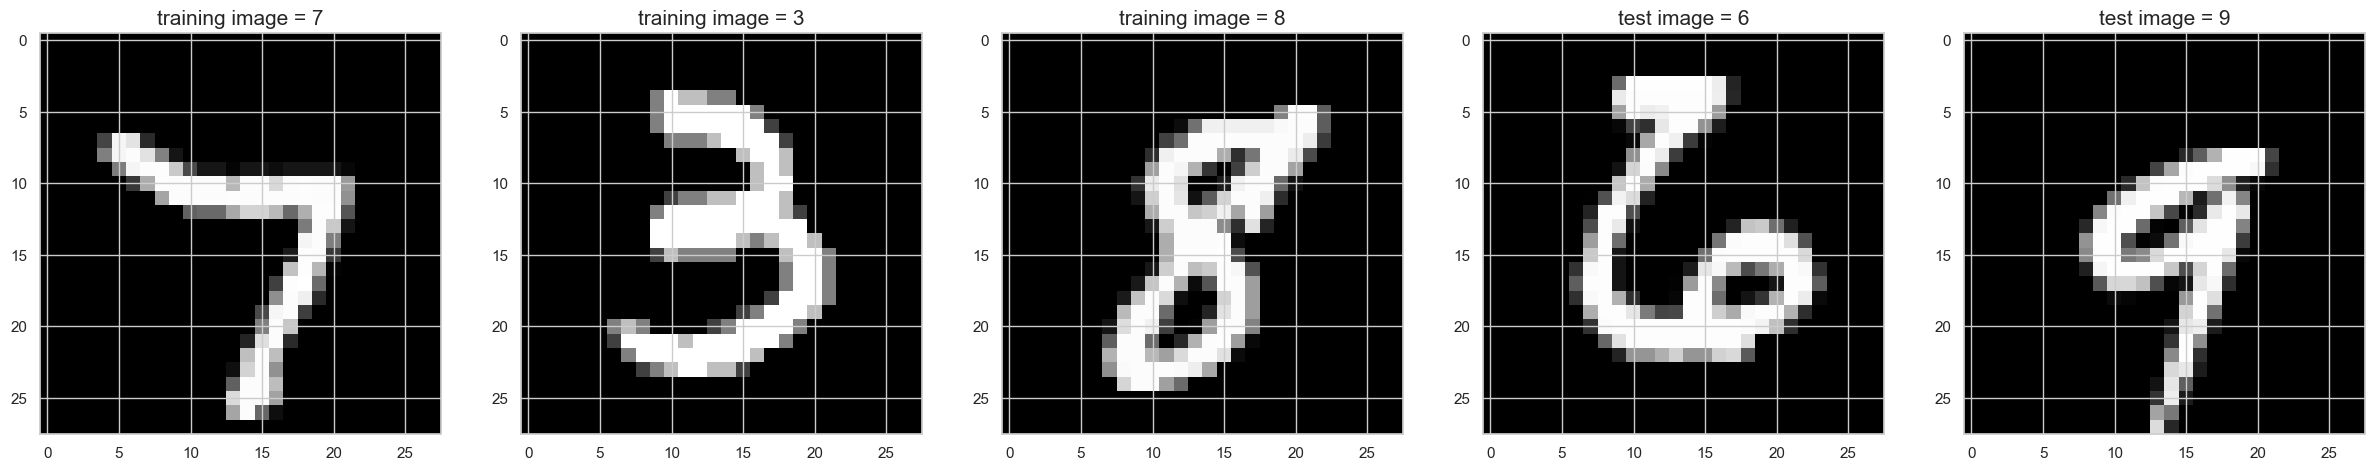

Reading 5 images (sequential selection)...
Reading 3 images (sequential selection)...
Applying gaussian noise (factor: 0.3)...
Original MNIST images:
Loading original data...
Reading 3 images (random selection)...
Reading 2 images (random selection)...
Displaying 3 training images and 2 test images


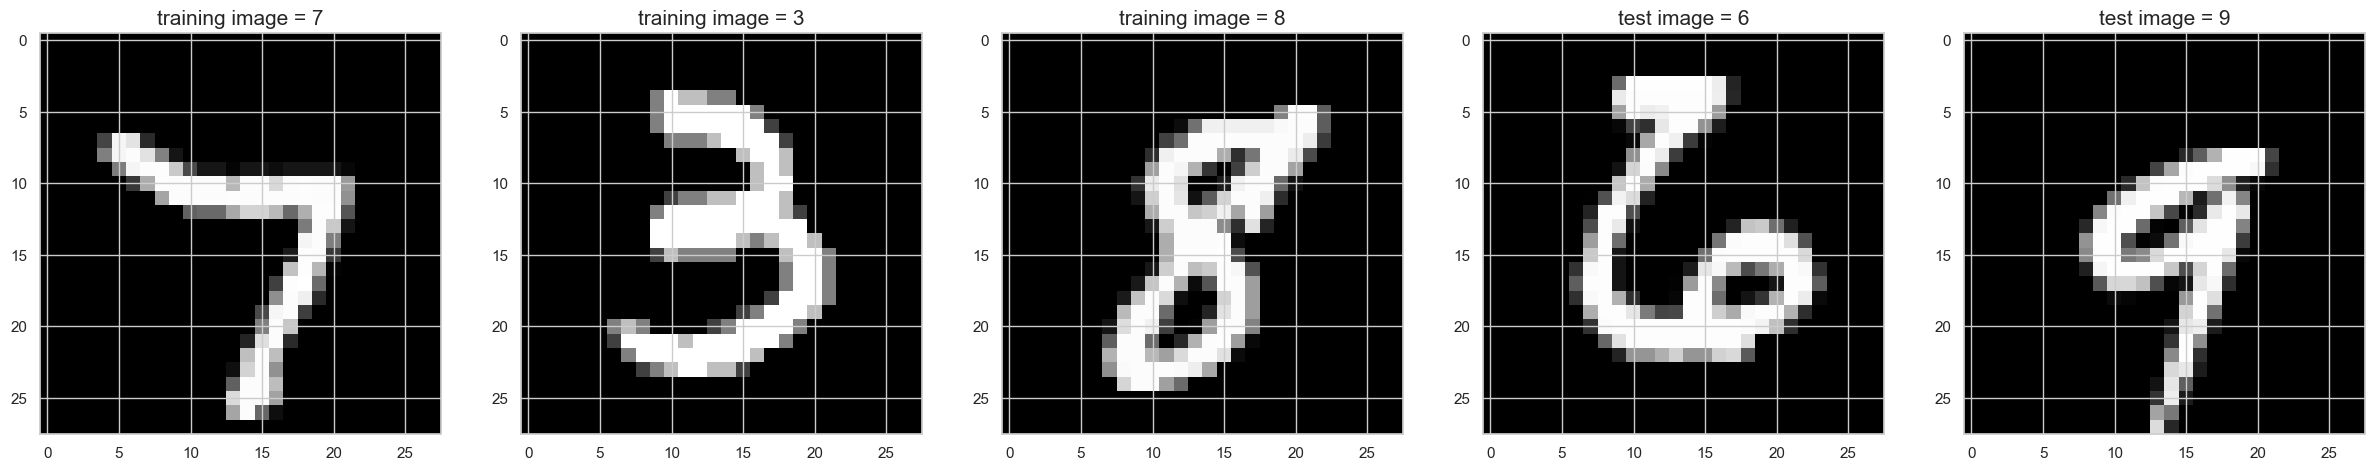


Same MNIST images with applied Gaussian noise:
Loading noisy data with (gaussian noise, factor: 0.3)...
Reading 3 images (random selection)...
Reading 2 images (random selection)...
Applying gaussian noise (factor: 0.3)...
Displaying 3 training images and 2 test images


Reading 5 images (sequential selection)...
Reading 3 images (sequential selection)...
Applying gaussian noise (factor: 0.3)...
Original MNIST images:
Loading original data...
Reading 3 images (random selection)...
Reading 2 images (random selection)...
Displaying 3 training images and 2 test images


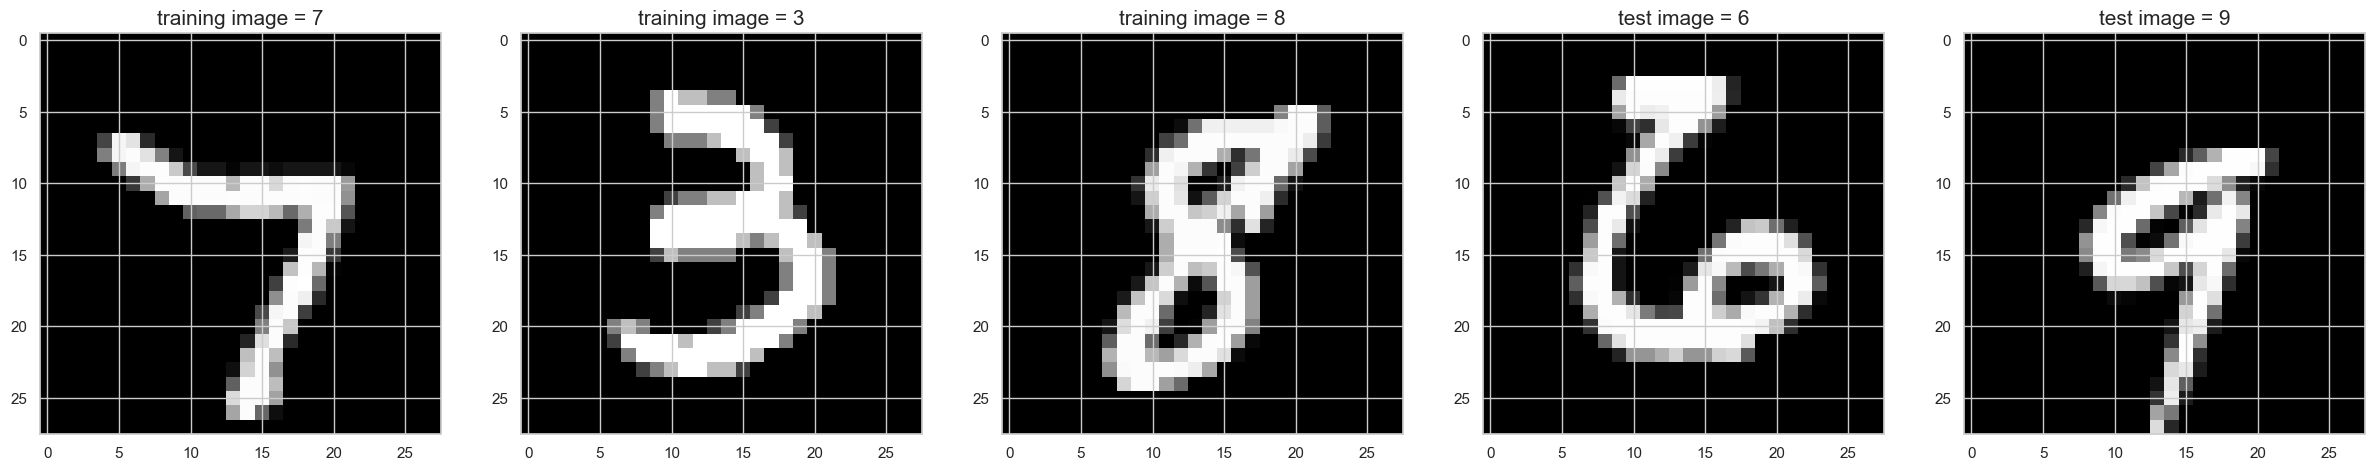


Same MNIST images with applied Gaussian noise:
Loading noisy data with (gaussian noise, factor: 0.3)...
Reading 3 images (random selection)...
Reading 2 images (random selection)...
Applying gaussian noise (factor: 0.3)...
Displaying 3 training images and 2 test images


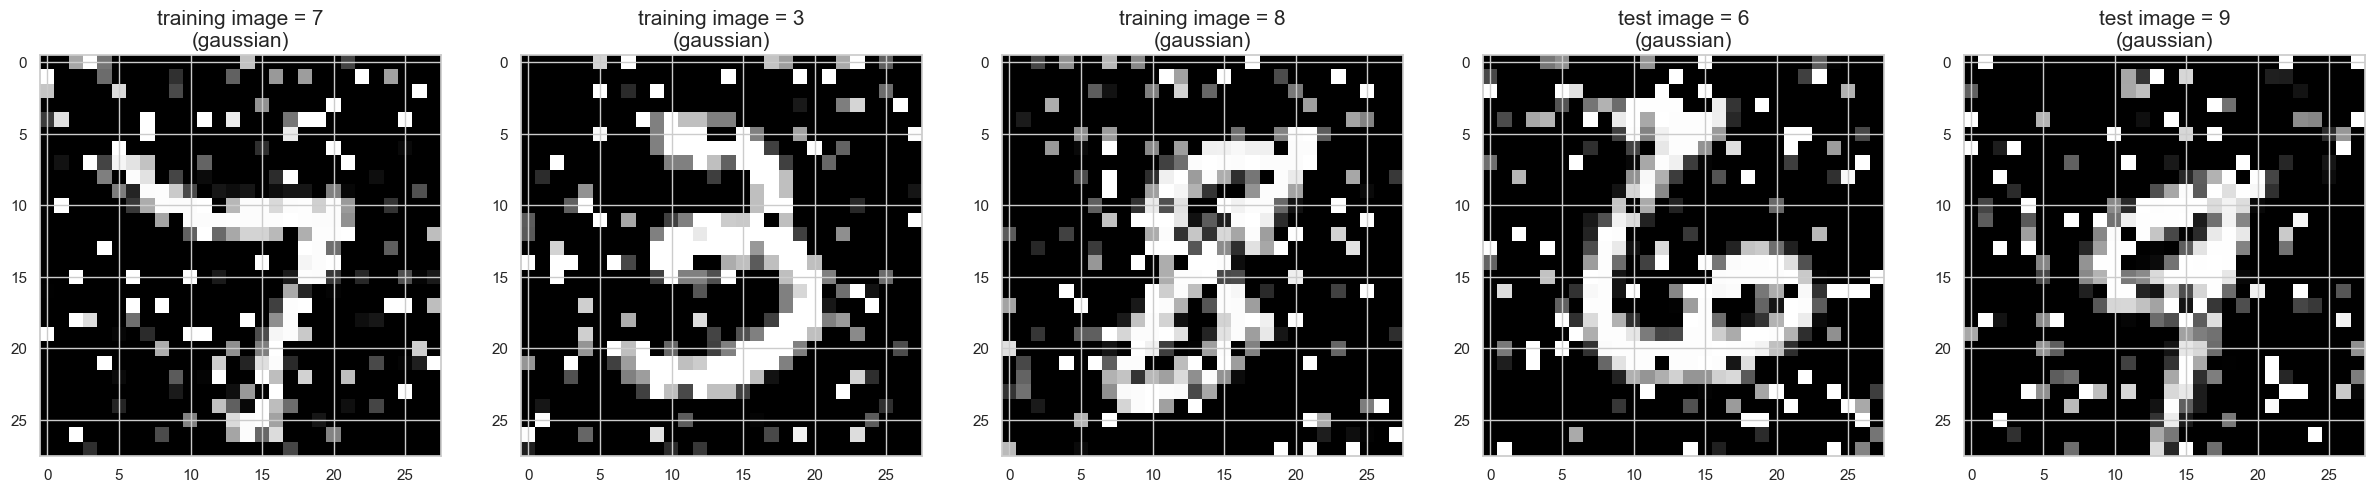

Reading 5 images (sequential selection)...
Reading 3 images (sequential selection)...
Applying gaussian noise (factor: 0.3)...
Original MNIST images:
Loading original data...
Reading 3 images (random selection)...
Reading 2 images (random selection)...
Displaying 3 training images and 2 test images


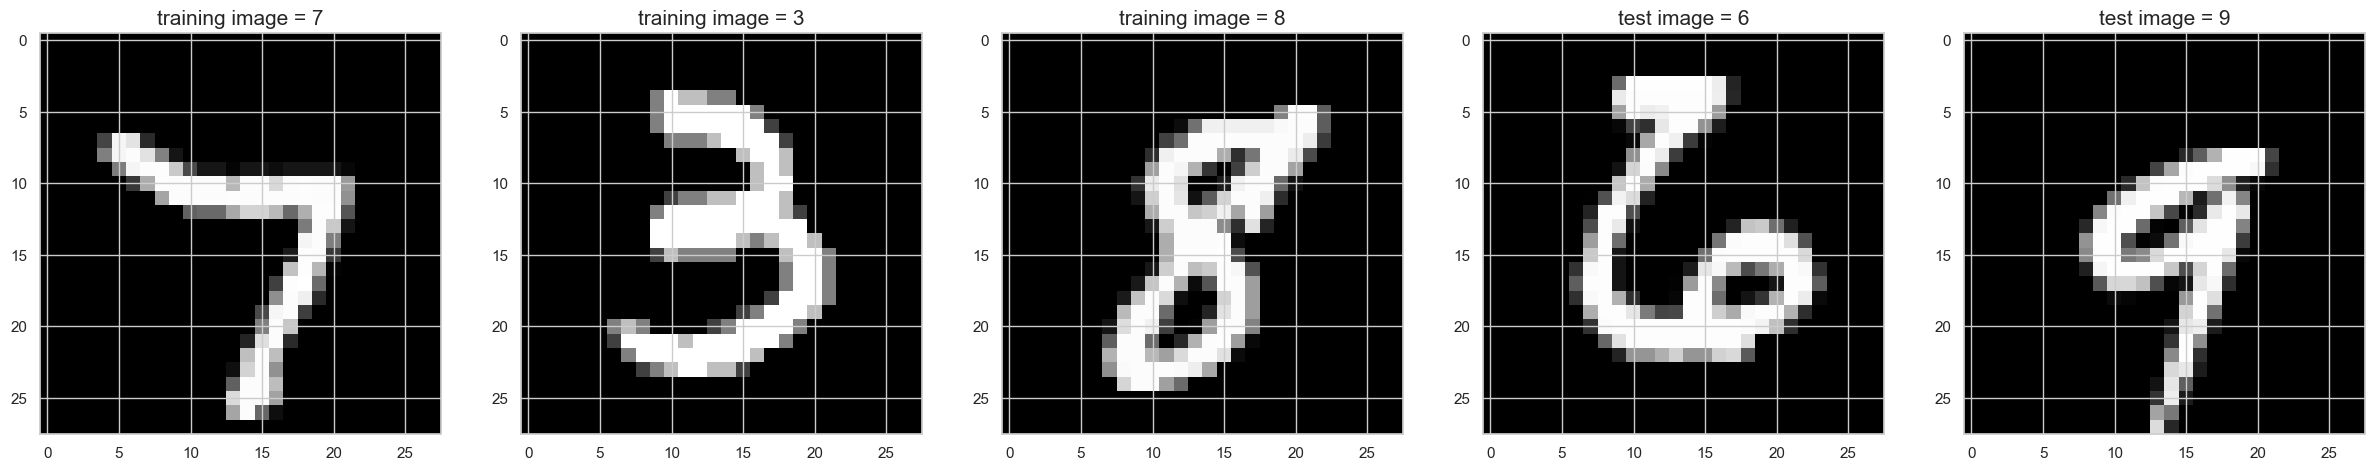


Same MNIST images with applied Gaussian noise:
Loading noisy data with (gaussian noise, factor: 0.3)...
Reading 3 images (random selection)...
Reading 2 images (random selection)...
Applying gaussian noise (factor: 0.3)...
Displaying 3 training images and 2 test images


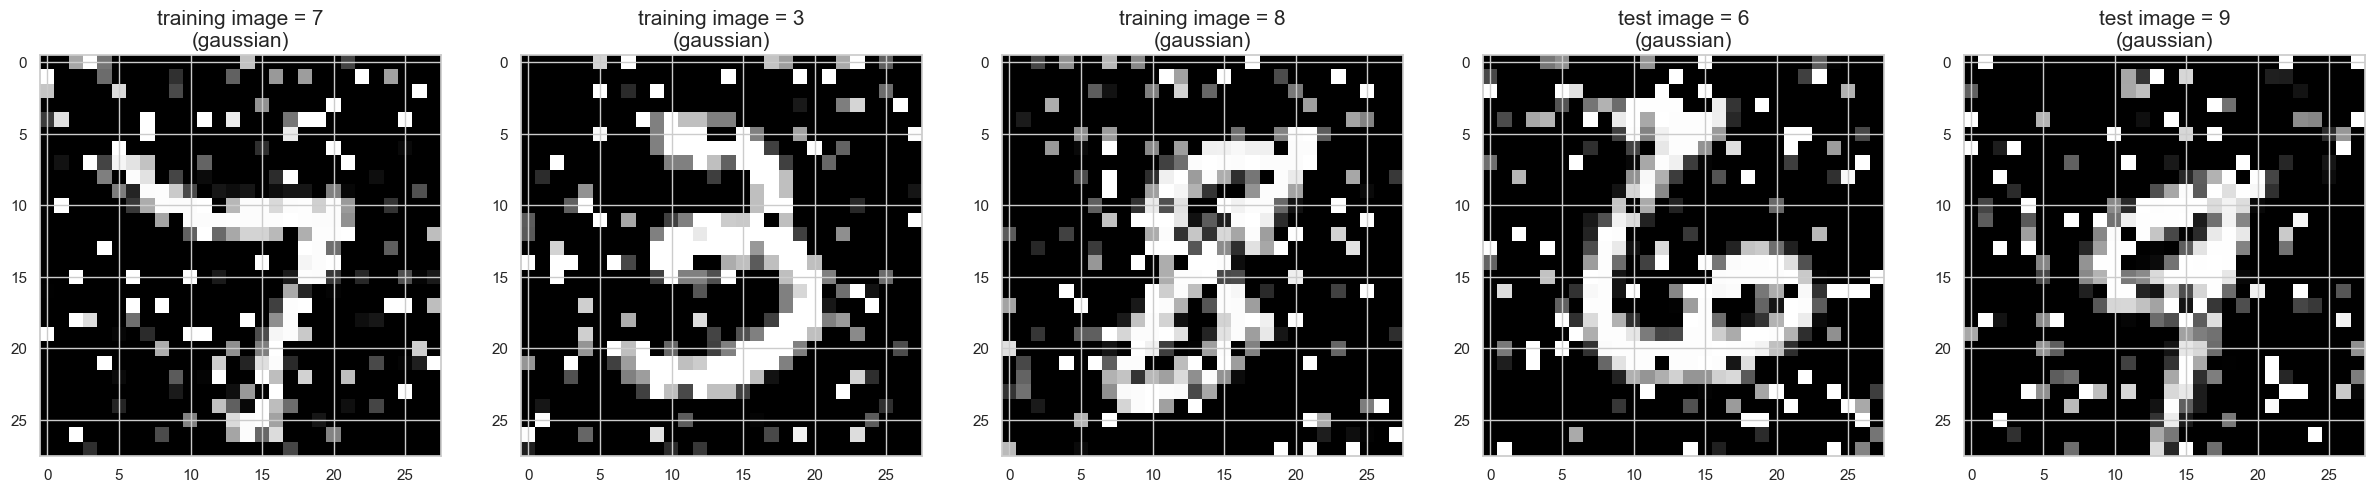

Loading all training data (100000 images)...
Loading 3 test images (sequential)...
CAPTCHA dataset loaded successfully!
Example CAPTCHA label: [7 4 0 3]


Reading 5 images (sequential selection)...
Reading 3 images (sequential selection)...
Applying gaussian noise (factor: 0.3)...
Original MNIST images:
Loading original data...
Reading 3 images (random selection)...
Reading 2 images (random selection)...
Displaying 3 training images and 2 test images


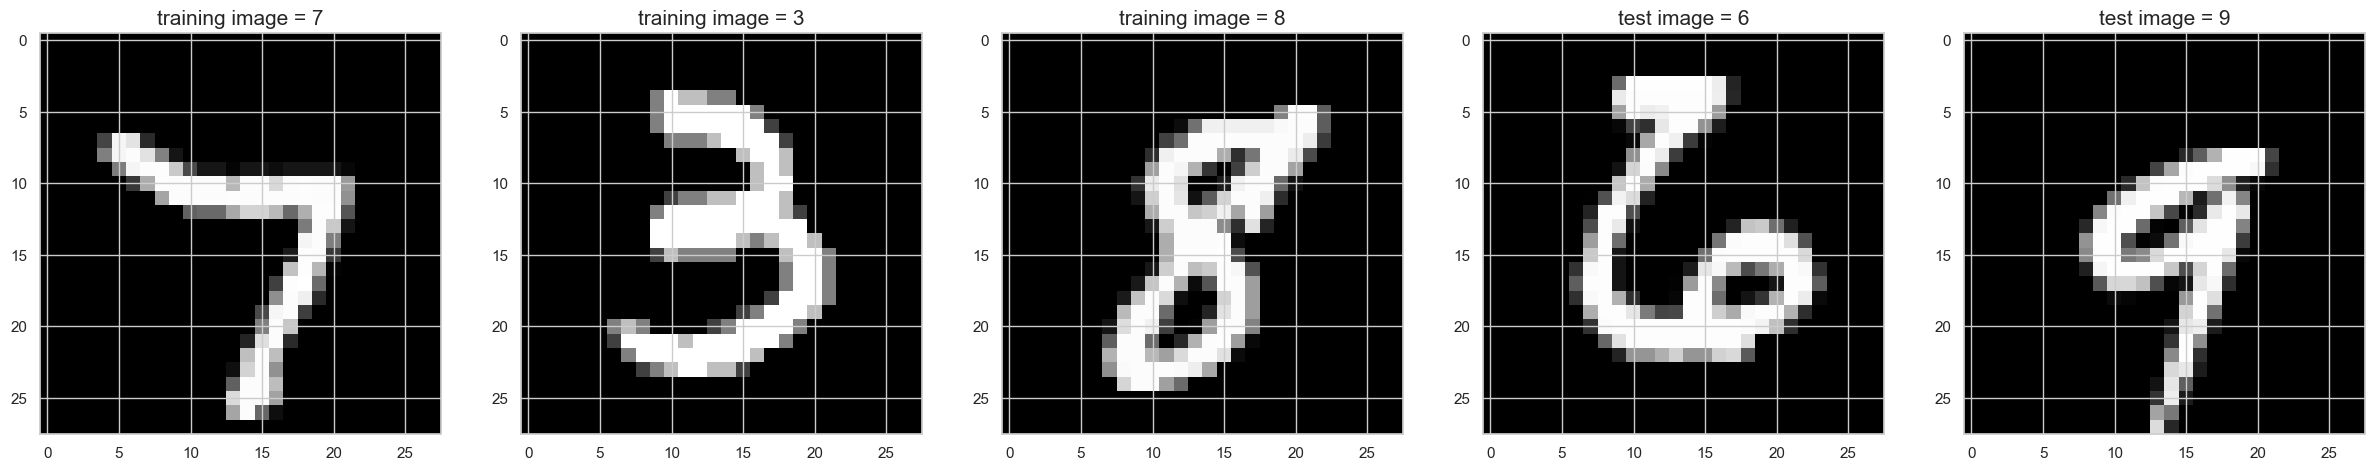


Same MNIST images with applied Gaussian noise:
Loading noisy data with (gaussian noise, factor: 0.3)...
Reading 3 images (random selection)...
Reading 2 images (random selection)...
Applying gaussian noise (factor: 0.3)...
Displaying 3 training images and 2 test images


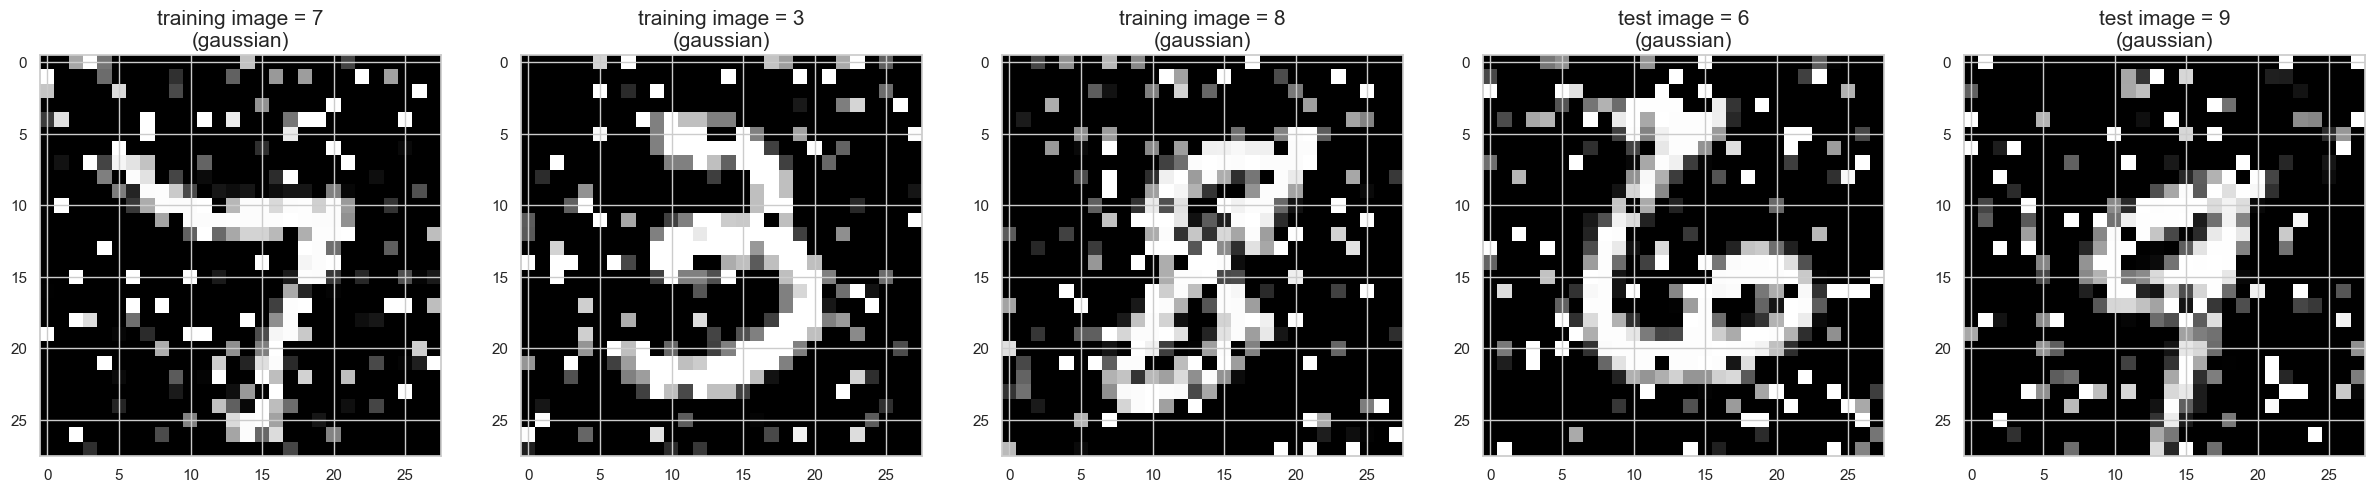

Loading all training data (100000 images)...
Loading 3 test images (sequential)...
CAPTCHA dataset loaded successfully!
Example CAPTCHA label: [7 4 0 3]


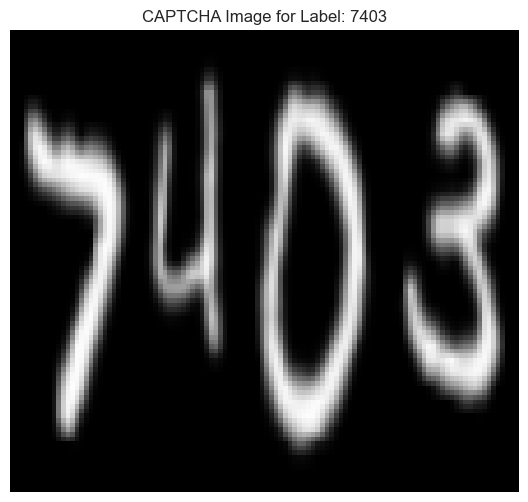

In [4]:
# Illustrative Examples of Key Methods

# 1. Loading MNIST data with applied Gaussian noise
(x_train_noisy, y_train_noisy), (x_test_noisy, y_test_noisy) = loader.load_data(
    apply_noise=True, noise_type='gaussian', noise_factor=0.3, num_images_train=5, num_images_test=3
)

# 2. Displaying MNIST images: first originals, then the same with Gaussian noise
print("Original MNIST images:")
loader.show_images(num_train=3, num_test=2, show_noisy=False, seed=42)

print("\nSame MNIST images with applied Gaussian noise:")
loader.show_images(num_train=3, num_test=2, show_noisy=True, noise_type='gaussian', noise_factor=0.3, seed=42)

# 3. Loading a CAPTCHA from .h5 and displaying it with its label
(x_train_captcha, y_train_captcha), (x_test_captcha, y_test_captcha) = loader.load_captcha_dataset(
    h5_filepath=os.path.join('..', 'data', 'captcha_data', 'captcha_dataset.h5'), num_images_test=3
)
print(f"Example CAPTCHA label: {y_test_captcha[0]}")  # Shows the label format (list of 4 digits)

# Display the corresponding CAPTCHA image
plt.imshow(x_test_captcha[0].squeeze(), cmap='gray')
plt.title(f"CAPTCHA Image for Label: {''.join(map(str, y_test_captcha[0]))}")
plt.axis('off')
plt.show()

## 2. Modeling: Multi-Head CNN Architecture

To address the problem of CAPTCHA reading, we selected a **Multi-Head CNN** (Convolutional Neural Network) architecture.

### Rationale for this Architecture
Classical methods often require slicing the image to isolate each character (segmentation) before recognition. With the introduction of noise, this segmentation becomes unreliable.
Our approach takes the **entire** image as input and features **4 independent output heads**, each learning to predict the digit at a specific position (1st, 2nd, 3rd, 4th).

### Architecture Overview
The architecture shares a common feature extraction backbone (convolutional layers) for all digits, before branching out.

![Multi-Head CNN Architecture Diagram](..\ressources\multi_head_ccn_schema.png)

In [ ]:
import multi_head_CNN 
import tensorflow as tf
import os

MODEL_PATH = os.path.join('..', 'data', 'models', 'multi_output_cnn.keras')

multi_head_CNN.train_and_evaluate(
        model_save_path=MODEL_PATH,
        apply_noise=True, 
        noise_type='salt_and_pepper', 
        noise_factor=0.2, 
        noise_factor_end=0.4, 
        noise_step=0.1,
        rgb_noise=False
    )

### Technical Details on Key Functions in `multi_head_CNN.py`

To complement the architecture overview, here is a summary of the essential functions used in `multi_head_CNN.py` for building, pre-processing, and training the multi-head CNN:

1. **Model Construction**:
   - `build_model()`: Creates the CNN architecture with a shared convolutional backbone (Conv2D layers with MaxPooling) and 4 separate dense heads for predicting each digit. Compiles the model with Adam optimizer and categorical cross-entropy loss for multi-output training.

2. **Data Pre-Processing**:
   - `preprocess_data(x_train, y_train, x_test, y_test)`: Normalizes image pixel values to [0,1] and converts the 4-digit labels into one-hot encoded arrays, preparing them for the multi-head outputs.

3. **Noise Application for Robustness**:
   - `apply_balanced_noise(images, noise_type, noise_factor, noise_factor_end, step, rgb_noise)`: Applies noise (Gaussian or salt-and-pepper) across a range of intensities (e.g., 0.3 to 1.0) with balanced distribution, ensuring the model trains on varied noise levels for better generalization.

4. **Training and Evaluation Pipeline**:
   - `train_and_evaluate(...)`: Orchestrates the full process: loads CAPTCHA data, applies noise if specified, preprocesses data, builds/trains the model, evaluates accuracy per digit, and saves the trained model.

These functions are critical for the multi-head CNN's implementation and robustness, enabling dynamic noise injection during training.

Model Architecture Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 110,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 98, 108,   │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 49, 54,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 47, 52,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 23, 26,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 21, 24,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 10, 12,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 7680)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    983,168 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit1_dense        │ (None, 64)        │      8,256 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit2_dense        │ (None, 64)        │      8,256 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit3_dense        │ (None, 64)        │      8,256 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit4_dense        │ (None, 64)        │      8,256 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit1 (Dense)      │ (None, 10)        │        650 │ digit1_dense[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit2 (Dense)      │ (None, 10)        │        650 │ digit2_dense[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit3 (Dense)      │ (None, 10)        │        650 │ digit3_dense[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit4 (Dense)      │ (None, 10)        │        650 │ digit4_dense[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,074,536 (4.10 MB)

 Trainable params: 1,074,536 (4.10 MB)

 Non-trainable params: 0 (0.00 B)

Loading all training data (100000 images)...
Loading 4 test images (sequential)...
CAPTCHA dataset loaded successfully!
Applying gaussian noise with 3 levels: [0.3, 0.45, 0.6]
  Level 0.30: processing 2 images (1-2)
  Level 0.45: processing 1 images (3-3)
  Level 0.60: processing 1 images (4-4)


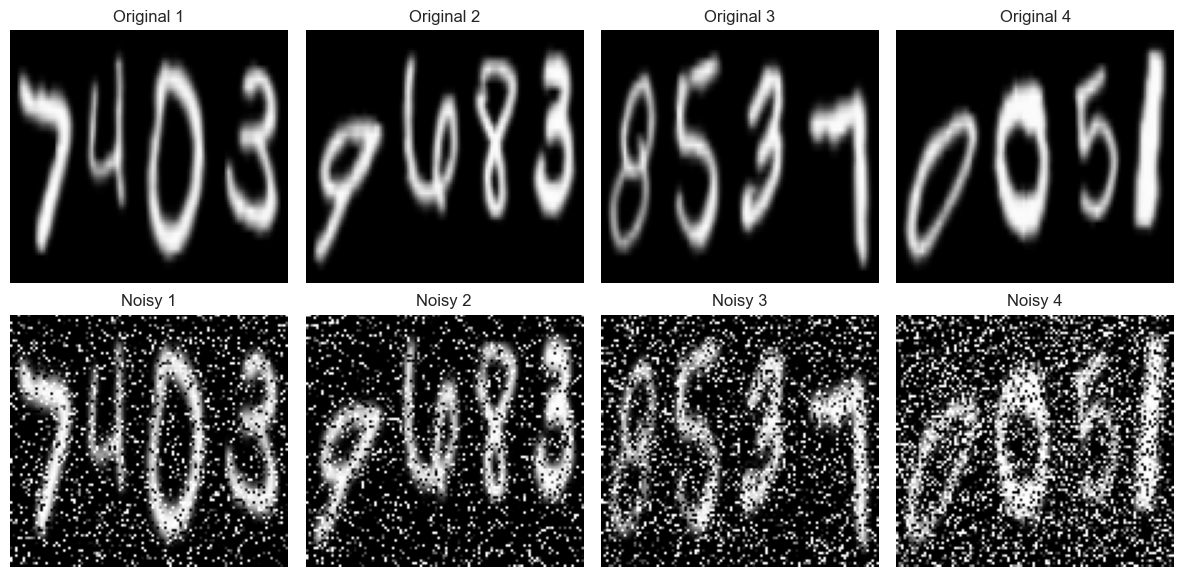

In [9]:
# Illustrative Examples of Key Functions from multi_head_CNN.py

# 1. Building the model and displaying its architecture summary
model = multi_head_CNN.build_model()
print("Model Architecture Summary:")
model.summary()

# 2. Demonstrating balanced noise application on CAPTCHA images
# Load a small set of CAPTCHA images
(x_train_captcha, _), (x_test_captcha, _) = loader.load_captcha_dataset(
    h5_filepath=os.path.join('..', 'data', 'captcha_data', 'captcha_dataset.h5'), num_images_test=4
)

# Apply balanced Gaussian noise from 0.3 to 0.6
noisy_images = multi_head_CNN.apply_balanced_noise(
    x_test_captcha, noise_type='gaussian', noise_factor=0.3, noise_factor_end=0.6, step=0.15, rgb_noise=False
)

# Visualize original vs noisy images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    axes[0, i].imshow(x_test_captcha[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')
    axes[1, i].imshow(noisy_images[i].squeeze(), cmap='gray')
    axes[1, i].set_title(f"Noisy {i+1}")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

## 3. Statistical Analysis and Robustness

In this section, we evaluate the robustness of our model and the OCR API against different levels and types of noise. The objectives are multiple:
- Quantify performance degradation as a function of noise.
- Compare the resilience of our specialized model to that of the general-purpose OCR API.
- Determine if combining both approaches can enhance recognition.
- Identify the CAPTCHAs that are most challenging for these models to recognize.

## 3.1. Baseline: OCR API

To benchmark the effectiveness of our specialized model, we compare it against an off-the-shelf solution: the **OCR.space** API.

> **Note**: Preliminary tests indicate that general-purpose OCR solutions (optimized for scanned documents) fail rapidly on our CAPTCHAs, even at very low (or zero) noise levels. Consequently, we restrict the noise factor here to **0.1** to maintain a feasible evaluation scope for the API.

Ensure that a `.env` file exists in the `src` directory containing your key: `OCR_api_KEY=...`.

### Technical Details on Key Functions in `OCR_api.py`

Here is a summary of the essential functions used in `OCR_api.py` for interacting with the OCR.space API:

1. **File-Based OCR Request**:
   - `ocr_space_file(filename, overlay, api_key, language, filetype, OCREngine)`: Sends a local image file to the OCR.space API for text recognition. Supports parameters like overlay, language, and OCR engine for customization.

2. **Single Image Processing and OCR**:
   - `ocr_space_one_image(image_data, api_key, language, filetype, OCREngine)`: Processes a single image in matrix format (e.g., numpy array), applies pre-processing (grayscale conversion, inversion, sharpening), saves it temporarily as a file, and sends it to the API for OCR. Returns the parsed text.

3. **Batch Testing on CAPTCHAs**:
   - `test_ocr_on_captcha(mnist_loader, api_key, h5_filepath, num_images, noise_factor, display_images)`: Generates CAPTCHAs with noise, processes each image using the API, and returns results with predictions, ground truth, and optional visualizations.

These functions handle image pre-processing and API communication, ensuring reliable OCR requests for CAPTCHA evaluation.

In [ ]:
import os
from dotenv import load_dotenv
from OCR_api import test_ocr_on_captcha

# Load configuration
load_dotenv(dotenv_path=os.path.join(".env")) 
api_key = os.getenv("OCR_API_KEY")

if api_key is None:
    print(" Error: API Key not found. Please verify that 'OCR_API_KEY' is present in 'src/.env'")
else:  

    h5_filepath = os.path.join('..','data', 'captcha_data', 'captcha_dataset.h5')
    
    if os.path.exists(h5_filepath):
        # OCR testing on CAPTCHAs with low noise intensity
        results = test_ocr_on_captcha(
            mnist_loader=loader,
            api_key=api_key,
            h5_filepath=h5_filepath,
            num_images=2,       # Limiting to 3 requests to avoid spamming the API
            noise_factor=0.1,   # Low noise level as the OCR is highly sensitive
            display_images=True
        )
        
        # Display text summary
        print("\n--- OCR Predictions Summary ---")
        for r in results:
            clean_pred = r['predicted'].replace(" ", "").replace("\n", "")
            print(f"Image {r['index']}: Predicted = '{clean_pred}', Ground Truth = '{r['true_label']}'")
    else:
        print(f"The file {h5_filepath} does not exist. Please execute the dataset generation (Previous Cell).")

### 3.2. Creation of an Evaluation Dataset
Initially, we will generate an evaluation dataset based on the different models by varying the type and level of noise applied to the images.

We will:
1.  Vary the noise intensity from **0.0 (clean)** to **0.5 (highly noisy)**.
2.  Test two types of noise: **Gaussian** and **Salt & Pepper**.
3.  Store these results in a **Pandas DataFrame** for analysis.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from MNIST import MnistDataloader
from multi_head_CNN import apply_balanced_noise
import os

# Load CAPTCHA dataset
data_dir = '..\data'
mnist_loader = MnistDataloader(data_dir=data_dir)
h5_filepath = os.path.join(data_dir, 'captcha_data', 'captcha_dataset.h5')
(x_train, y_train), (x_test, y_test) = mnist_loader.load_captcha_dataset(h5_filepath=h5_filepath, num_images_test=100)
# Limit to 100 test images for demo
# Load the model
model_path = os.path.join(data_dir, 'models', 'multi_output_cnn.keras')
model = tf.keras.models.load_model(model_path)
# Prepare data for CSV
data_rows = []

for idx, (image, true_solution) in enumerate(zip(x_test, y_test)):
    # Determine image format
    if len(image.shape) == 3 and image.shape[-1] == 1:  # Grayscale
        image_format = 0
        image_data = image.astype(int)  # numpy array of ints 0-255
    elif len(image.shape) == 3 and image.shape[-1] == 3:  # RGB
        image_format = 1
        image_data = image.astype(int)  # 3D array (H, W, C)
    else:
        continue  # Skip if not matching
    
    solution = ''.join(map(str, true_solution))  # Convert list to string
    
    # First, add the no-noise case
    noisy_image = image
    # Preprocess for model
    if image_format == 0:  # Grayscale
        image_gray = noisy_image
    else:  # RGB
        image_gray = np.mean(noisy_image, axis=-1, keepdims=True)
    image_normalized = image_gray.astype('float32') / 255.0
    image_batch = np.expand_dims(image_normalized, axis=0)
    
    # Predict
    predictions = model.predict(image_batch, verbose=0)
    predicted_digits = [int(np.argmax(pred[0])) for pred in predictions]
    response = ''.join(map(str, predicted_digits))
    
    # Add row for no noise
    data_rows.append({
        'id': idx,
        'image_format': image_format,
        'image_data': image_data,  # numpy array
        'solution': solution,
        'noise': 0,
        'noise_type': 'none',
        'noise_factor': 0.0,
        'response': response
    })
    
    # Now, for each noise type, generate balanced noise from 0.3 to 1.0
    for noise_type in ['gaussian', 'salt_and_pepper']:
        # Generate noise levels uniformly from 0.3 to 1.0 with step 0.1
        noise_levels = []
        current = 0.3
        while current <= 1.0 + 1e-9:
            noise_levels.append(round(current, 5))
            current += 0.1
        num_levels = len(noise_levels)
        
        # Repeat the image num_levels times
        images_batch = [image] * num_levels
        
        # Apply balanced noise using the function from multi_head_CNN
        noisy_images = apply_balanced_noise(images_batch, noise_type, 0.3, 1.0, 0.1, rgb_noise=(image_format == 1))
        
        # For each noisy image and corresponding level
        for noisy_image, level in zip(noisy_images, noise_levels):
            # Preprocess for model
            if image_format == 0:  # Grayscale
                image_gray = noisy_image
            else:  # RGB
                image_gray = np.mean(noisy_image, axis=-1, keepdims=True)
            image_normalized = image_gray.astype('float32') / 255.0
            image_batch = np.expand_dims(image_normalized, axis=0)
            
            # Predict
            predictions = model.predict(image_batch, verbose=0)
            predicted_digits = [int(np.argmax(pred[0])) for pred in predictions]
            response = ''.join(map(str, predicted_digits))
            
            # Add row
            data_rows.append({
                'id': idx,
                'image_format': image_format,
                'image_data': image_data,  # numpy array
                'solution': solution,
                'noise': 1,
                'noise_type': noise_type,
                'noise_factor': level,
                'model_response': response
            })
# Create DataFrame
df = pd.DataFrame(data_rows)

# Save to CSV (note: numpy arrays will be stored as strings; for full arrays, consider HDF5 or pickle)
df.to_csv('data\captcha_evaluation.csv', index=False)
print("CSV file 'captcha_evaluation.csv' created successfully.")

In [129]:
#We add some prediction of OCR API
import random
from OCR_api import ocr_space_one_image
from dotenv import load_dotenv
df["OCR_response"] = np.nan

indexes = random.sample(range(df["id"].max()), k=10)  # Select 10 random indexes for OCR predictions
print(indexes)

load_dotenv(dotenv_path=".env") 
api_key = os.getenv("OCR_API_KEY")
for idx in indexes:
    image_data = df[df["id"]==idx]["image_data"].values[0]
    text=ocr_space_one_image(image_data=image_data, api_key=api_key)
    df.loc[df["id"]==idx, "OCR_response"] = text

[15, 14, 89, 24, 82, 45, 79, 47, 67, 75]
Prédiction de l'image...
{'ParsedResults': [{'TextOverlay': {'Lines': [], 'HasOverlay': False, 'Message': 'Text overlay is not provided as it is not requested'}, 'TextOrientation': '0', 'FileParseExitCode': 1, 'ParsedText': '862г', 'ErrorMessage': '', 'ErrorDetails': ''}], 'OCRExitCode': 1, 'IsErroredOnProcessing': False, 'ProcessingTimeInMilliseconds': '953', 'SearchablePDFURL': 'Searchable PDF not generated as it was not requested.'}
Prédiction de l'image...


C:\Users\admin\AppData\Local\Temp\ipykernel_19820\781620194.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '862г' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df["id"]==idx, "OCR_response"] = text


{'ParsedResults': [{'TextOverlay': {'Lines': [], 'HasOverlay': False, 'Message': 'Text overlay is not provided as it is not requested'}, 'TextOrientation': '0', 'FileParseExitCode': 1, 'ParsedText': '>606', 'ErrorMessage': '', 'ErrorDetails': ''}], 'OCRExitCode': 1, 'IsErroredOnProcessing': False, 'ProcessingTimeInMilliseconds': '625', 'SearchablePDFURL': 'Searchable PDF not generated as it was not requested.'}
Prédiction de l'image...
{'ParsedResults': [{'TextOverlay': {'Lines': [], 'HasOverlay': False, 'Message': 'Text overlay is not provided as it is not requested'}, 'TextOrientation': '0', 'FileParseExitCode': 1, 'ParsedText': '3493', 'ErrorMessage': '', 'ErrorDetails': ''}], 'OCRExitCode': 1, 'IsErroredOnProcessing': False, 'ProcessingTimeInMilliseconds': '640', 'SearchablePDFURL': 'Searchable PDF not generated as it was not requested.'}
Prédiction de l'image...
{'ParsedResults': [{'TextOverlay': {'Lines': [], 'HasOverlay': False, 'Message': 'Text overlay is not provided as it is 

In [ ]:
df['correct'] = df.apply(
    lambda row: int(all(a == b for a, b in zip(row['solution'], row['model_response']))),
    axis=1
)
# Compute the number of correct digits for each prediction
df['n_correct_digits'] = df.apply(
    lambda row: sum(1 for a, b in zip(row['solution'], row['model_response']) if a == b), 
    axis=1
)

# Evaluate each digit independently
for digit_pos in range(4):
    df[f'correct_digit_{digit_pos}'] = df.apply(
        lambda row: int(row['solution'][digit_pos] == row['model_response'][digit_pos]),
        axis=1
    )

## 3.3. Global Performance Analysis of the CNN Model

In this section, we analyze the overall performance of our multi-head CNN model using the evaluation dataset created in section 3.2. We focus on descriptive statistics to assess robustness against noise, without retraining or re-evaluating the model. Key metrics include:

- **Global Accuracy**: Percentage of CAPTCHAs where all 4 digits are correctly predicted.
- **Average Accuracy per Digit**: Mean accuracy across the 4 positions, highlighting potential weaknesses in specific digits.
- **Performance by Noise Level**: Trends in accuracy as noise intensity increases (from 0.0 to 1.0).
- **Comparison by Noise Type**: Differences between Gaussian and Salt & Pepper noise.

We leverage the existing DataFrame (`df`) for these analyses, grouping data by noise factors and types.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure df is loaded (from section 3.2)
# df should already be in memory; otherwise, reload from CSV
# df = pd.read_csv('data/captcha_evaluation.csv')  # Uncomment if necessary

# 1. Global descriptive statistics
print("=== Global Performance Statistics ===")
total_captchas = len(df)
global_accuracy = df['correct'].mean() * 100  # Percentage of CAPTCHAs with all 4 digits correct
avg_correct_digits = df['n_correct_digits'].mean()  # Average correct digits per CAPTCHA
print(f"Total CAPTCHAs evaluated: {total_captchas}")
print(f"Global Accuracy (all 4 digits correct): {global_accuracy:.2f}%")
print(f"Average Correct Digits per CAPTCHA: {avg_correct_digits:.2f}/4")

# Accuracy per digit (average across all noise levels)
digit_accuracies = []
for i in range(4):
    acc = df[f'correct_digit_{i}'].mean() * 100
    digit_accuracies.append(acc)
    print(f"Accuracy for Digit {i+1}: {acc:.2f}%")

# 2. Performance by noise level (grouping by noise_factor)
noise_performance = df.groupby('noise_factor').agg({
    'correct': 'mean',
    'n_correct_digits': 'mean'
}).reset_index()
noise_performance['correct'] *= 100  # Convert to %
noise_performance['n_correct_digits'] /= 4  # Normalize to [0,1] for consistency

# Visualization: Accuracy vs Noise Level
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Global accuracy (all digits correct)
ax[0].plot(noise_performance['noise_factor'], noise_performance['correct'], marker='o', label='Global Accuracy')
ax[0].set_xlabel('Noise Factor')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Global Accuracy vs Noise Level')
ax[0].grid(True)
ax[0].legend()

# Subplot 2: Average accuracy per digit
ax[1].plot(noise_performance['noise_factor'], noise_performance['n_correct_digits'] * 100, marker='s', color='orange', label='Avg Correct Digits (%)')
ax[1].set_xlabel('Noise Factor')
ax[1].set_ylabel('Average Correct Digits (%)')
ax[1].set_title('Average Correct Digits vs Noise Level')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()

# 3. Comparison by noise type (Gaussian vs Salt & Pepper)
noise_type_performance = df[df['noise'] == 1].groupby(['noise_type', 'noise_factor']).agg({
    'correct': 'mean',
    'n_correct_digits': 'mean'
}).reset_index()
noise_type_performance['correct'] *= 100
noise_type_performance['n_correct_digits'] /= 4

# Visualization: Comparison of noise types
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

for noise_type in ['gaussian', 'salt_and_pepper']:
    subset = noise_type_performance[noise_type_performance['noise_type'] == noise_type]
    ax[0].plot(subset['noise_factor'], subset['correct'], marker='o', label=f'{noise_type.capitalize()}')
    ax[1].plot(subset['noise_factor'], subset['n_correct_digits'] * 100, marker='s', label=f'{noise_type.capitalize()}')

ax[0].set_xlabel('Noise Factor')
ax[0].set_ylabel('Global Accuracy (%)')
ax[0].set_title('Global Accuracy by Noise Type')
ax[0].legend()
ax[0].grid(True)

ax[1].set_xlabel('Noise Factor')
ax[1].set_ylabel('Avg Correct Digits (%)')
ax[1].set_title('Avg Correct Digits by Noise Type')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

# 4. Distribution of performances (histogram of accuracies per digit)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i in range(4):
    sns.histplot(df[f'correct_digit_{i}'], bins=2, ax=axes[i//2, i%2], kde=False)
    axes[i//2, i%2].set_title(f'Distribution of Accuracy for Digit {i+1}')
    axes[i//2, i%2].set_xlabel('Correct (0/1)')
    axes[i//2, i%2].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Statistical summary by noise type
print("\n=== Summary by Noise Type ===")
summary = df.groupby('noise_type').agg({
    'correct': ['mean', 'std'],
    'n_correct_digits': ['mean', 'std']
})
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary *= 100  # Convert to %
print(summary)

To analyze the overall performance of our multi-head CNN model, we leverage the `evaluate_model.py` script, which provides statistical evaluation tools for pre-trained models. This approach focuses on descriptive statistics and robustness testing against noise, using already trained models without retraining. Key functions include noise-level evaluations and performance metrics.

As an example, we demonstrate the `evaluate_captcha_vs_noise` function, which assesses model accuracy across a range of noise intensities (e.g., Salt & Pepper noise from 0.0 to 0.5). This generates plots showing per-digit and average accuracies, highlighting degradation patterns.

In [ ]:
from evaluate_model import evaluate_captcha_vs_noise

# Example: Evaluate the CAPTCHA model against Salt & Pepper noise
# It evaluates the pre-trained multi-head CNN on varying noise levels and plots results
evaluate_captcha_vs_noise(
    model_path='../data/models/multi_output_cnn.keras',  # Path to the saved model
    data_dir='../data',  # Directory containing CAPTCHA data
    noise_type='salt_and_pepper',  # Type of noise to apply
    noise_factor_start=0.0,  # Starting noise level
    noise_factor_end=0.5,  # Ending noise level
    noise_step=0.05,  # Step size for noise levels
    rgb_noise=False,  # Apply noise in grayscale
    sample_size=None  # Use all test data for accurate results
)

### 3.4. Performance Comparison between the CNN Model and the OCR API

In this section, we compare the performance of our specialized multi-head CNN model against the general-purpose OCR.space API using the evaluation dataset created in section 3.2. The goal is to quantify the robustness gap between a domain-specific model (trained on CAPTCHA data) and a generic OCR tool, particularly under noise conditions.

Key comparisons include:
- **Global Accuracy**: Percentage of CAPTCHAs where all 4 digits are correctly predicted by each model.
- **Average Accuracy per Digit**: Mean accuracy across the 4 positions for the CNN model, with OCR accuracy treated as a single prediction (since OCR returns a string).
- **Performance by Noise Level**: Trends in accuracy as noise intensity increases, highlighting where the CNN outperforms the OCR API.
- **Comparison by Noise Type**: Differences in resilience between Gaussian and Salt & Pepper noise for both models.

We leverage the existing DataFrame (`df`) for these analyses, focusing on rows where OCR predictions are available.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure df is loaded (from section 3.2)
# df should already be in memory; otherwise, reload from CSV
# df = pd.read_csv('data/captcha_evaluation.csv')  # Uncomment if necessary

# Filter to data with OCR predictions (non-NaN)
df_ocr = df.dropna(subset=['OCR_response']).copy()

# Clean OCR responses (remove spaces, non-digits, limit to 4 chars)
df_ocr['OCR_response_clean'] = df_ocr['OCR_response'].str.replace(r'\D', '', regex=True).str[:4]

# Evaluate OCR accuracy
df_ocr['ocr_correct'] = df_ocr.apply(
    lambda row: int(row['solution'] == row['OCR_response_clean']),
    axis=1
)

# 1. Global descriptive statistics comparison
print("=== Global Performance Comparison ===")
try:
    cnn_global_accuracy = global_accuracy
    cnn_avg_correct_digits = avg_correct_digits
    print(f"CNN Global Accuracy (all 4 digits correct): {cnn_global_accuracy:.2f}%")
    print(f"CNN Average Correct Digits per CAPTCHA: {cnn_avg_correct_digits:.2f}/4")
except NameError:
    print("Error: Please run the cells in section 3.3 to compute global_accuracy and avg_correct_digits.")

ocr_global_accuracy = df_ocr['ocr_correct'].mean() * 100
print(f"OCR Global Accuracy: {ocr_global_accuracy:.2f}%")

# Accuracy per digit for CNN (reused)
try:
    print("CNN Accuracy per Digit:")
    for i, acc in enumerate(digit_accuracies):
        print(f"  Digit {i+1}: {acc:.2f}%")
except NameError:
    print("Error: Please run the cells in section 3.3 to compute digit_accuracies.")

# 2. Performance by noise level comparison
try:
    cnn_noise_performance = noise_performance.copy()
    cnn_noise_performance['model'] = 'CNN'
    cnn_noise_performance = cnn_noise_performance.rename(columns={'correct': 'accuracy'})
except NameError:
    print("Error: Please run the cells in section 3.3 to compute noise_performance.")
    cnn_noise_performance = pd.DataFrame()

ocr_noise_performance = df_ocr.groupby('noise_factor').agg({'ocr_correct': 'mean'}).reset_index()
ocr_noise_performance['ocr_correct'] *= 100
ocr_noise_performance['model'] = 'OCR'
ocr_noise_performance = ocr_noise_performance.rename(columns={'ocr_correct': 'accuracy'})

if not cnn_noise_performance.empty:
    combined_noise = pd.concat([cnn_noise_performance[['noise_factor', 'accuracy', 'model']], ocr_noise_performance])
    
    # Visualization: Accuracy vs Noise Level
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(data=combined_noise, x='noise_factor', y='accuracy', hue='model', marker='o', ax=ax)
    ax.set_xlabel('Noise Factor')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Accuracy vs Noise Level: CNN vs OCR')
    ax.grid(True)
    plt.show()

# 3. Comparison by noise type
try:
    cnn_noise_type = summary.reset_index()
    cnn_noise_type['model'] = 'CNN'
    cnn_noise_type = cnn_noise_type.rename(columns={'correct_mean': 'accuracy_mean', 'correct_std': 'accuracy_std'})
except NameError:
    print("Error: Please run the cells in section 3.3 to compute summary.")
    cnn_noise_type = pd.DataFrame()

ocr_noise_type = df_ocr[df_ocr['noise'] == 1].groupby('noise_type').agg({'ocr_correct': ['mean', 'std']})
ocr_noise_type.columns = ['accuracy_mean', 'accuracy_std']
ocr_noise_type['accuracy_mean'] *= 100
ocr_noise_type['accuracy_std'] *= 100
ocr_noise_type = ocr_noise_type.reset_index()
ocr_noise_type['model'] = 'OCR'

if not cnn_noise_type.empty:
    combined_type = pd.concat([cnn_noise_type[['noise_type', 'accuracy_mean', 'model']], ocr_noise_type[['noise_type', 'accuracy_mean', 'model']]])
    
    # Visualization: Accuracy by Noise Type
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(data=combined_type, x='noise_type', y='accuracy_mean', hue='model', ax=ax)
    ax.set_xlabel('Noise Type')
    ax.set_ylabel('Mean Accuracy (%)')
    ax.set_title('Mean Accuracy by Noise Type: CNN vs OCR')
    ax.grid(True)
    plt.show()

print("\n=== Summary Statistics ===")
print(f"OCR evaluated on {len(df_ocr)} CAPTCHAs with predictions.")
print(f"CNN outperforms OCR by {cnn_global_accuracy - ocr_global_accuracy:.2f}% in global accuracy.")

### 3.5. Identification of the Most Challenging CAPTCHAs to Recognize

In this subsection, we perform descriptive statistics to identify patterns in CAPTCHA recognition difficulties using the evaluation DataFrame (`df`). The goal is to determine which CAPTCHAs are hardest for the multi-head CNN to recognize and derive characteristics of an "optimal" CAPTCHA (one that maximizes errors for security purposes).

Key analyses include:
- **Most Confused Digits**: Frequency of errors per digit position and common misclassifications.
- **Best/Worst Predicted Combinations**: Accuracy by unique digit sequences, highlighting sequences with high/low success rates.
- **Error Visualizations**: Bar plots or histograms for digits with the highest error rates.
- **Impact of Digit Patterns**: Whether repeated digits (e.g., 4 identical digits) or paired patterns (e.g., two pairs of different digits) affect accuracy.
- **Optimal CAPTCHA Characteristics**: Summary statistics to define features that make CAPTCHAs challenging (e.g., low accuracy for certain patterns).

These insights use pre-computed predictions from `df`, focusing on noise-affected data for robustness analysis.